### Load libraries

In [145]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import wilcoxon
from itertools import combinations

### Read data

In [146]:
icer = pd.read_csv('../data/processed/icer_observed.csv')
low = gpd.read_file('../data/processed/low_res.shp')
high = gpd.read_file('../data/processed/high_res.shp')
rf_preds = pd.read_csv('../data/processed/df_combined_with_predictions_rf_popden_hdi.csv')

### Process data

In [147]:
#first method of disaggregation, divide the cases evenly among all the districts
#firstly, extract the total number of cases in DKI Jakarta, so high['Cases'] when high['Province'] == 'DKI Jakarta', for every year
df_jakarta = low[low['Province'] == 'DKI Jakarta']
df_java = low[low['Province'] == 'Jawa Barat']

df_jakarta.head()

,Province,x,y,Year,Cases,Population,HDI,Area_sq_km,Pop_den,geometry
0,DKI Jakarta,106.834386,-6.200345,2020,1226,804069,80.345000,664.01,1210.929052,"MULTIPOLYGON (((106.38346 -5.18521, 106.38331 ..."
1,DKI Jakarta,106.834386,-6.200345,2021,1061,799633,80.633333,664.01,1204.248430,"MULTIPOLYGON (((106.38346 -5.18521, 106.38331 ..."
2,DKI Jakarta,106.834386,-6.200345,2022,2123,795198,81.146667,661.23,1202.604238,"MULTIPOLYGON (((106.38346 -5.18521, 106.38331 ..."
3,DKI Jakarta,106.834386,-6.200345,2023,1564,790763,81.708333,660.98,1196.349360,"MULTIPOLYGON (((106.38346 -5.18521, 106.38331 ..."


In [148]:
#create a dataframe containing total number of cases in dengue in each year from dki jakarta n west java df
df_jakarta_yearly_total_cases = pd.DataFrame(df_jakarta.groupby('Year')['Cases'].sum())
df_java_yearly_total_cases = pd.DataFrame(df_java.groupby('Year')['Cases'].sum())

In [149]:
#check head
df_jakarta_yearly_total_cases.head()

,Cases
Year,
2020,1226
2021,1061
2022,2123
2023,1564


### Disaggregation with equal proportions and ICER adjustments

In [150]:
#from this, extract the total number of districts in DKI Jakarta from high df, so count the number of unique values of district when province column = dki jakarta
df_jakarta_districts = len(pd.DataFrame(high[high['Province'] == 'DKI Jakarta']['District'].unique()))
df_java_districts = len(pd.DataFrame(high[high['Province'] == 'Jawa Barat']['District'].unique()))

In [151]:
print(df_jakarta_districts)

6


In [152]:
#list out all the district - level dengue cases estimates each year
year_2020_jkt = int(df_jakarta_yearly_total_cases.loc[2020] / df_jakarta_districts)
year_2021_jkt = int(df_jakarta_yearly_total_cases.loc[2021] / df_jakarta_districts)
year_2022_jkt = int(df_jakarta_yearly_total_cases.loc[2022] / df_jakarta_districts)
year_2023_jkt = int(df_jakarta_yearly_total_cases.loc[2023] / df_jakarta_districts)

year_2020_java = int(df_java_yearly_total_cases.loc[2020] / df_java_districts)
year_2021_java = int(df_java_yearly_total_cases.loc[2021] / df_java_districts)
year_2022_java = int(df_java_yearly_total_cases.loc[2022] / df_java_districts)
year_2023_java = int(df_java_yearly_total_cases.loc[2023] / df_java_districts)

C:\Users\jessi\AppData\Local\Temp\ipykernel_9244\516498921.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2020_jkt = int(df_jakarta_yearly_total_cases.loc[2020] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_9244\516498921.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2021_jkt = int(df_jakarta_yearly_total_cases.loc[2021] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_9244\516498921.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2022_jkt = int(df_jakarta_yearly_total_cases.loc[2022] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_9244\516498921.py:5: FutureWarning: Calling int on a single element Series is deprecat

In [153]:
#append the disaggregated counts to the high_res file ina  new column called cases_bm_equal, only if the Province column is dki jakarta
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2020), 'cases_bm_equal'] = year_2020_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2021), 'cases_bm_equal'] = year_2021_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2022), 'cases_bm_equal'] = year_2022_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2023), 'cases_bm_equal'] = year_2023_jkt

high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2020), 'cases_bm_equal'] = year_2020_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2021), 'cases_bm_equal'] = year_2021_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2022), 'cases_bm_equal'] = year_2022_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2023), 'cases_bm_equal'] = year_2023_java

In [154]:
high.head()

,District,x,y,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,geometry,cases_bm_equal
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,Jawa Barat,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",3091.0
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,Jawa Barat,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2739.0
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,Jawa Barat,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",4716.0
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,Jawa Barat,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2744.0
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,Jawa Barat,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",3091.0


In [155]:
#merge this with icer df
icer = pd.merge(icer, high[['Province', 'District', 'Year', 'cases_bm_equal']], on=['Province', 'District', 'Year'], how='left')

In [156]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,burden_vaccine,healthcare_cost_non_vaccine,healthcare_cost_vaccine,payer_cost_non_vaccine,payer_cost_vaccine,cases_bm_equal
0,0,BANDUNG,Jawa Barat,14495160,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,264217,26618814,352828922,16066984,345497041,3091.0
1,1,BANDUNG,Jawa Barat,14662620,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,264217,26618814,352828922,16066984,345497041,2739.0
2,2,BANDUNG,Jawa Barat,14830092,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,264217,26618814,352828922,16066984,345497041,4716.0
3,3,BANDUNG,Jawa Barat,14997564,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,264217,26618814,352828922,16066984,345497041,2744.0
4,4,BANDUNG BARAT,Jawa Barat,7153344,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,264217,26618814,352828922,16066984,345497041,3091.0


In [157]:
#calculate ICER for disaggregation with equal proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
icer['cost_factor'] = icer['cases_bm_equal'] / (icer['burden_non_vaccine'] + icer['burden_vaccine'])

icer['qaly_lost_scaled_vaccine'] = icer['qaly_le_scaled_vaccine'] * icer['cost_factor']
icer['qaly_lost_scaled_nonvaccine'] = icer['qaly_le_scaled_nonvaccine'] * icer['cost_factor']


In [158]:
# Scale costs
icer['healthcare_cost_vaccine_scaled'] = icer['healthcare_cost_vaccine'] * icer['cost_factor']
icer['healthcare_cost_nonvaccine_scaled'] = icer['healthcare_cost_non_vaccine'] * icer['cost_factor']
icer['payer_cost_vaccine_scaled'] = icer['payer_cost_vaccine'] * icer['cost_factor']
icer['payer_cost_nonvaccine_scaled'] = icer['payer_cost_non_vaccine'] * icer['cost_factor']

In [159]:
#compute icer
icer['icer_healthcare_equal_bm'] = abs(icer['healthcare_cost_vaccine_scaled'] - icer['healthcare_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])
icer['icer_payer_equal_bm'] = abs(icer['payer_cost_vaccine_scaled'] - icer['payer_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])

### Population-proportion disaggregation and icer calculations

In [160]:
#get df containing yearly total populations
df_jakarta_yearly_total_pop = pd.DataFrame(df_jakarta.groupby('Year')['Population'].sum())
df_java_yearly_total_pop = pd.DataFrame(df_java.groupby('Year')['Population'].sum())

df_jakarta_yearly_total_pop.head()

,Population
Year,
2020,804069
2021,799633
2022,795198
2023,790763


In [161]:
#merge the two dfs by Year
df_jakarta_final = df_jakarta_yearly_total_cases.merge(df_jakarta_yearly_total_pop, on='Year')
df_java_final = df_java_yearly_total_cases.merge(df_java_yearly_total_pop, on='Year')

#get another column called df_jakarta_final and df_java_final called Province, for merging
df_jakarta_final['Province'] = 'DKI Jakarta'
df_java_final['Province'] = 'Jawa Barat'

#append the suffix _Prov to both "Cases" and "Population" c0olumns in df_jakarta_final and df_java_final:
df_jakarta_final.columns = [col + '_Prov' if col in ['Cases', 'Population'] else col for col in df_jakarta_final.columns]
df_java_final.columns = [col + '_Prov' if col in ['Cases', 'Population'] else col for col in df_java_final.columns]

In [162]:
# Reset index of df_jakarta_final and df_java_final to make 'Year' a regular column
df_jakarta_final = df_jakarta_final.reset_index()
df_java_final = df_java_final.reset_index()
#check
df_jakarta_final.head()

,Year,Cases_Prov,Population_Prov,Province
0,2020,1226,804069,DKI Jakarta
1,2021,1061,799633,DKI Jakarta
2,2022,2123,795198,DKI Jakarta
3,2023,1564,790763,DKI Jakarta


In [163]:
#merge df_jakarta_final and df_java_final tgt by row
df_final = pd.concat([df_jakarta_final, df_java_final], axis=0)

In [164]:
#now appd this to the high-res dataset: so it means that if the year is 2020 cases_prop_bm = high_res["Population"]/df_jakarta_final["Population"] * df_jakarta_final["Cases"]

#merge to the high_res df by Year and Province
high = pd.merge(high, df_final[['Year', 'Province', 'Population_Prov', 'Cases_Prov']], on=['Year', 'Province'], how='left')


In [165]:
high.head()

,District,x,y,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,geometry,cases_bm_equal,Population_Prov,Cases_Prov
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,Jawa Barat,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",3091.0,152087060,55644
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,Jawa Barat,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2739.0,153780104,49308
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,Jawa Barat,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",4716.0,155473164,84888
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,Jawa Barat,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",2744.0,157166220,49396
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,Jawa Barat,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",3091.0,152087060,55644


In [166]:
#calculate the disaggregation by multiplying the total num of cases per province with the pop in the district / pop in the province
high['cases_prop_bm'] = high['Population'] / high['Population_Prov'] * high['Cases_Prov']

In [167]:
#icer calculations
#merge this with icer df
icer = pd.merge(icer, high[['Province', 'District', 'Year', 'cases_prop_bm']], on=['Province', 'District', 'Year'], how='left')

In [168]:
#calculate ICER for disaggregation with population-based proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
icer['cost_factor'] = icer['cases_prop_bm'] / (icer['burden_non_vaccine'] + icer['burden_vaccine'])

icer['qaly_lost_scaled_vaccine'] = icer['qaly_le_scaled_vaccine'] * icer['cost_factor']
icer['qaly_lost_scaled_nonvaccine'] = icer['qaly_le_scaled_nonvaccine'] * icer['cost_factor']


In [169]:
# Scale costs
icer['healthcare_cost_vaccine_scaled'] = icer['healthcare_cost_vaccine'] * icer['cost_factor']
icer['healthcare_cost_nonvaccine_scaled'] = icer['healthcare_cost_non_vaccine'] * icer['cost_factor']
icer['payer_cost_vaccine_scaled'] = icer['payer_cost_vaccine'] * icer['cost_factor']
icer['payer_cost_nonvaccine_scaled'] = icer['payer_cost_non_vaccine'] * icer['cost_factor']

In [170]:
#compute icer
icer['icer_healthcare_prop_bm'] = abs(icer['healthcare_cost_vaccine_scaled'] - icer['healthcare_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])
icer['icer_payer_prop_bm'] = abs(icer['payer_cost_vaccine_scaled'] - icer['payer_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])

In [171]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,...,qaly_lost_scaled_nonvaccine,healthcare_cost_vaccine_scaled,healthcare_cost_nonvaccine_scaled,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,icer_healthcare_equal_bm,icer_payer_equal_bm,cases_prop_bm,icer_healthcare_prop_bm,icer_payer_prop_bm
0,0,BANDUNG,Jawa Barat,14495160,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,...,1600.477651,2.893713e+06,218313.166073,2.833581e+06,131772.743380,5408.317941,5461.702270,5303.335360,5408.317941,5461.702270
1,1,BANDUNG,Jawa Barat,14662620,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,...,1420.231712,2.565282e+06,193535.060969,2.511975e+06,116816.802132,5402.967419,5456.298935,4701.417467,5402.967419,5456.298935
2,2,BANDUNG,Jawa Barat,14830092,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,...,2446.049696,4.418156e+06,333323.203451,4.326345e+06,201192.231054,5402.965214,5456.296708,8097.197081,5402.965214,5456.296708
3,3,BANDUNG,Jawa Barat,14997564,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,...,1423.392662,2.571933e+06,194036.813927,2.518487e+06,117119.657727,5404.945422,5458.296463,4713.606215,5404.945422,5458.296463
4,4,BANDUNG BARAT,Jawa Barat,7153344,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,...,777.051225,1.428044e+06,107737.284490,1.398369e+06,65029.690132,5497.285294,5551.547801,2617.189612,5497.285294,5551.547801


### Random-forest-based (hdi and pop den) aggregation and icer calculations

In [172]:
rf_preds.head()

,Unnamed: 0,District,x,y,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,geometry,Predicted_Cases
0,0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,Jawa Barat,9180,14495160,8198.805403,POLYGON ((107.73309340000009 -6.81399609999994...,NaN
1,1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,Jawa Barat,8008,14662620,8293.524740,POLYGON ((107.73309340000009 -6.81399609999994...,NaN
2,2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,Jawa Barat,16764,14830092,8388.250865,POLYGON ((107.73309340000009 -6.81399609999994...,NaN
3,3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,Jawa Barat,4020,14997564,8482.976990,POLYGON ((107.73309340000009 -6.81399609999994...,4185.308337
4,4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,Jawa Barat,3864,7153344,5478.257273,POLYGON ((107.40945450000004 -6.68851489999997...,2047.263489


In [173]:
#merge the rf_preds cases to the high and icer dfs:
#rename Predicted_Cases to rf_preds
rf_preds = rf_preds.rename(columns={'Predicted_Cases': 'rf_preds'})
high = pd.merge(high, rf_preds[['Population', 'Cases', 'Year', 'rf_preds', 'District']], on=['Population', 'Cases', 'Year', 'District'], how='left')
icer = pd.merge(icer, rf_preds[['Population', 'Cases', 'Year', 'rf_preds', 'District']], on=['Population', 'Year', 'District'], how='left')

In [174]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,...,healthcare_cost_nonvaccine_scaled,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,icer_healthcare_equal_bm,icer_payer_equal_bm,cases_prop_bm,icer_healthcare_prop_bm,icer_payer_prop_bm,Cases,rf_preds
0,0,BANDUNG,Jawa Barat,14495160,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,...,218313.166073,2.833581e+06,131772.743380,5408.317941,5461.702270,5303.335360,5408.317941,5461.702270,9180,NaN
1,1,BANDUNG,Jawa Barat,14662620,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,...,193535.060969,2.511975e+06,116816.802132,5402.967419,5456.298935,4701.417467,5402.967419,5456.298935,8008,NaN
2,2,BANDUNG,Jawa Barat,14830092,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,...,333323.203451,4.326345e+06,201192.231054,5402.965214,5456.296708,8097.197081,5402.965214,5456.296708,16764,NaN
3,3,BANDUNG,Jawa Barat,14997564,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,...,194036.813927,2.518487e+06,117119.657727,5404.945422,5458.296463,4713.606215,5404.945422,5458.296463,4020,4185.308337
4,4,BANDUNG BARAT,Jawa Barat,7153344,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,...,107737.284490,1.398369e+06,65029.690132,5497.285294,5551.547801,2617.189612,5497.285294,5551.547801,3864,2047.263489


In [175]:
# calculate icer for rf
# calculate ICER for disaggregation with population-based proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
icer['cost_factor'] = icer['rf_preds'] / (icer['burden_non_vaccine'] + icer['burden_vaccine'])

icer['qaly_lost_scaled_vaccine'] = icer['qaly_le_scaled_vaccine'] * icer['cost_factor']
icer['qaly_lost_scaled_nonvaccine'] = icer['qaly_le_scaled_nonvaccine'] * icer['cost_factor']

In [176]:
# Scale costs
icer['healthcare_cost_vaccine_scaled'] = icer['healthcare_cost_vaccine'] * icer['cost_factor']
icer['healthcare_cost_nonvaccine_scaled'] = icer['healthcare_cost_non_vaccine'] * icer['cost_factor']
icer['payer_cost_vaccine_scaled'] = icer['payer_cost_vaccine'] * icer['cost_factor']
icer['payer_cost_nonvaccine_scaled'] = icer['payer_cost_non_vaccine'] * icer['cost_factor']

In [177]:
#compute icer
icer['icer_healthcare_rf'] = abs(icer['healthcare_cost_vaccine_scaled'] - icer['healthcare_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])
icer['icer_payer_rf'] = abs(icer['payer_cost_vaccine_scaled'] - icer['payer_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])

In [178]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,...,payer_cost_nonvaccine_scaled,icer_healthcare_equal_bm,icer_payer_equal_bm,cases_prop_bm,icer_healthcare_prop_bm,icer_payer_prop_bm,Cases,rf_preds,icer_healthcare_rf,icer_payer_rf
0,0,BANDUNG,Jawa Barat,14495160,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,...,NaN,5408.317941,5461.702270,5303.335360,5408.317941,5461.702270,9180,NaN,NaN,NaN
1,1,BANDUNG,Jawa Barat,14662620,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,...,NaN,5402.967419,5456.298935,4701.417467,5402.967419,5456.298935,8008,NaN,NaN,NaN
2,2,BANDUNG,Jawa Barat,14830092,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,...,NaN,5402.965214,5456.296708,8097.197081,5402.965214,5456.296708,16764,NaN,NaN,NaN
3,3,BANDUNG,Jawa Barat,14997564,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,...,103992.963686,5404.945422,5458.296463,4713.606215,5404.945422,5458.296463,4020,4185.308337,5404.945422,5458.296463
4,4,BANDUNG BARAT,Jawa Barat,7153344,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,...,50868.653045,5497.285294,5551.547801,2617.189612,5497.285294,5551.547801,3864,2047.263489,5497.285294,5551.547801


# Evaluate the Predicted Cases produced by different methods

### Evaluate the ICER calculations produced by different models and which one is closest to the observed ones



 ICER Evaluation from Healthcare Provider's Perspective

 Performance Metrics:
         Method          MAE         RMSE     MAPE (%)
             RF 1.364242e-12 1.772932e-12 2.479810e-14
    Equal Split 1.894781e-12 2.395530e-12 3.423678e-14
Pop-Based Split 1.942150e-12 2.557322e-12 3.510283e-14


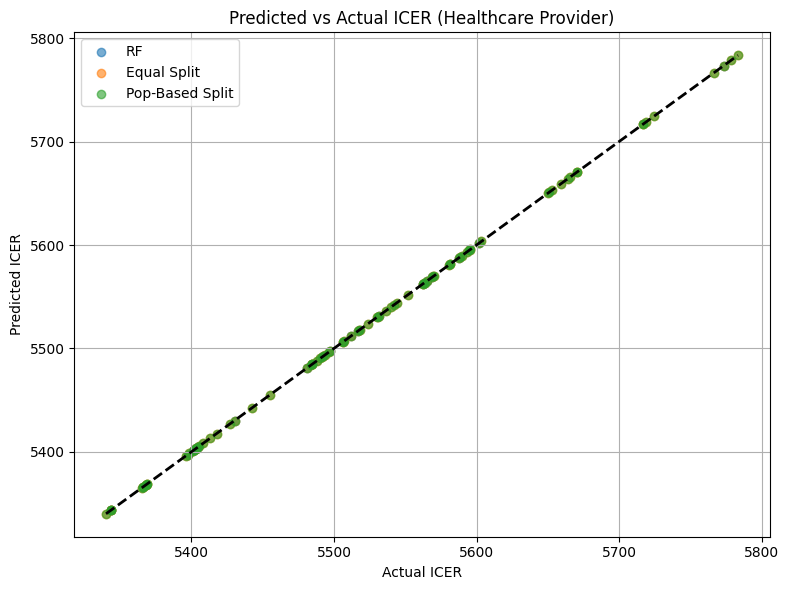

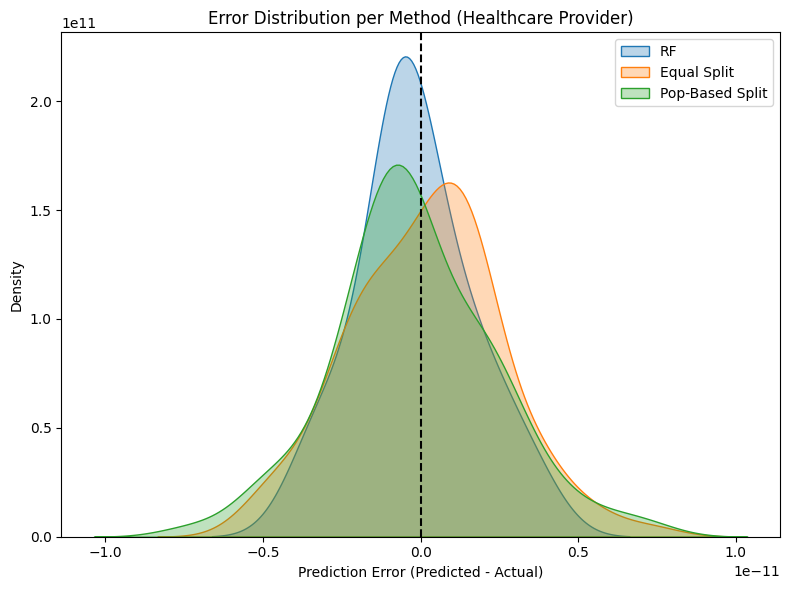

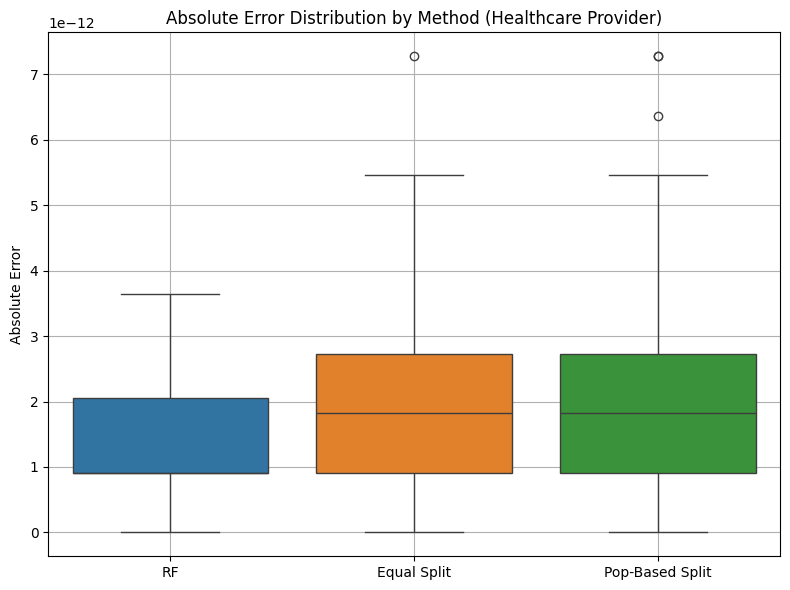


 Wilcoxon Signed-Rank Tests (Absolute Errors):
RF vs Equal Split: p = 0.3995 → no significant difference
RF vs Pop-Based Split: p = 0.2886 → no significant difference
Equal Split vs Pop-Based Split: p = 0.6772 → no significant difference


 ICER Evaluation from Payer's Perspective

 Performance Metrics:
         Method          MAE         RMSE     MAPE (%)
             RF 1.409717e-12 1.737587e-12 2.541914e-14
    Equal Split 1.980046e-12 2.464672e-12 3.544476e-14
Pop-Based Split 1.980046e-12 2.630403e-12 3.541563e-14


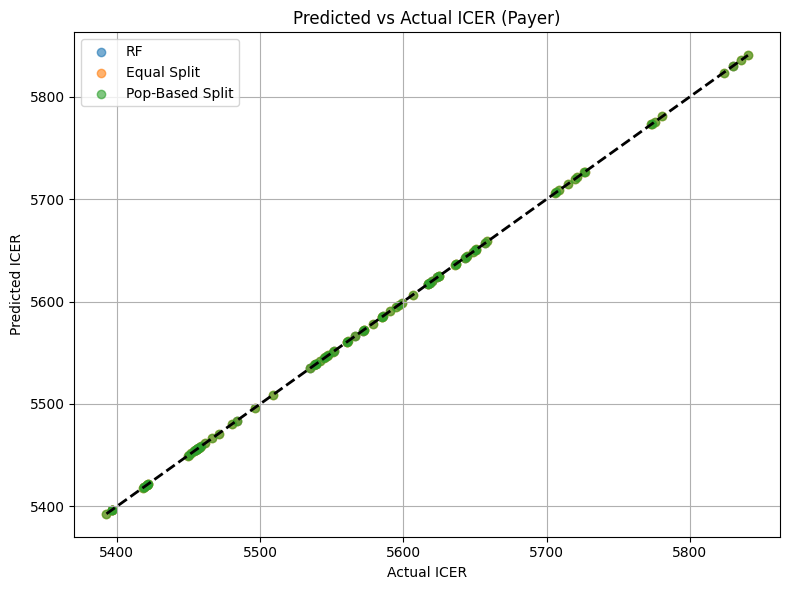

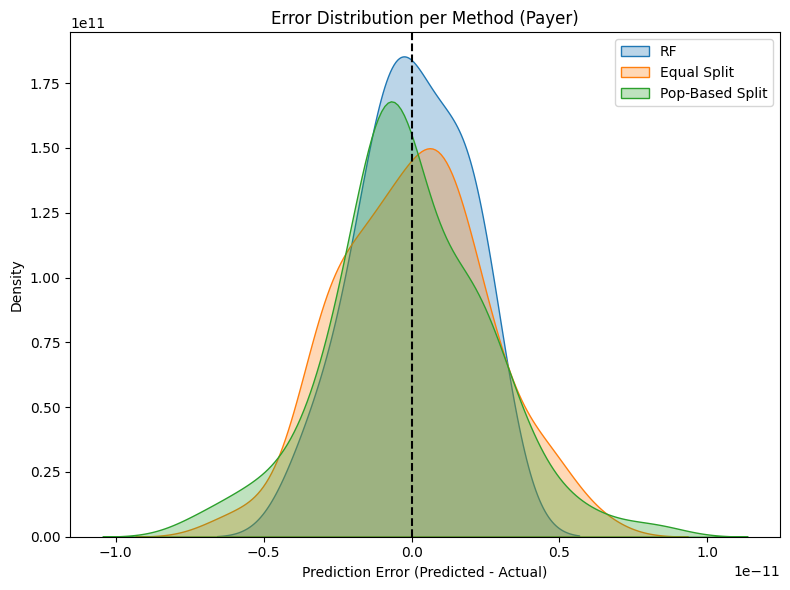

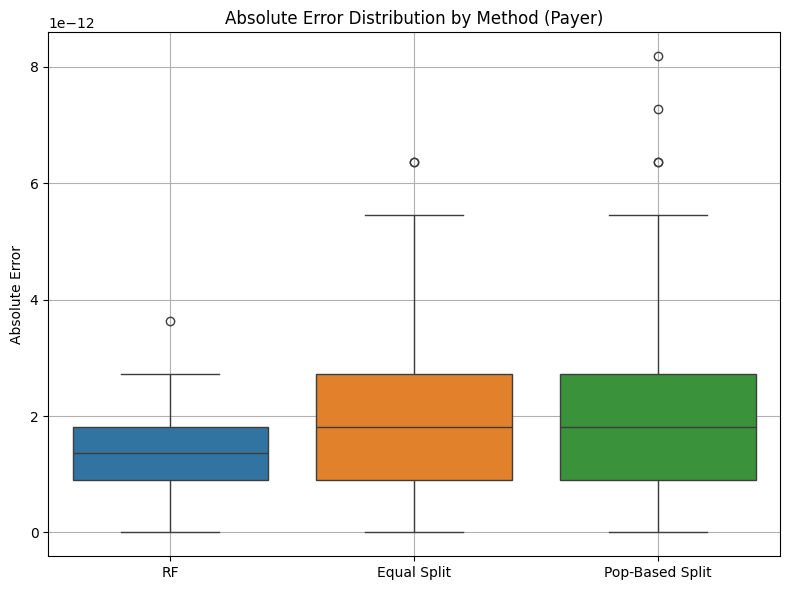


 Wilcoxon Signed-Rank Tests (Absolute Errors):
RF vs Equal Split: p = 0.3563 → no significant difference
RF vs Pop-Based Split: p = 0.7694 → no significant difference
Equal Split vs Pop-Based Split: p = 1.0000 → no significant difference


In [ ]:
# Define ICER method columns per perspective

perspectives = {
    'Healthcare Provider': {
        'true': 'icer_healthcare_observed',
        'methods': {
            'RF': 'icer_healthcare_rf',
            'Equal Split': 'icer_healthcare_equal_bm',
            'Pop-Based Split': 'icer_healthcare_prop_bm'
        }
    },
    'Payer': {
        'true': 'icer_payer_observed',
        'methods': {
            'RF': 'icer_payer_rf',
            'Equal Split': 'icer_payer_equal_bm',
            'Pop-Based Split': 'icer_payer_prop_bm'
        }
    }
}

for perspective, setup in perspectives.items():
    print(f"\n\n ICER Evaluation from {perspective}'s Perspective")

    true_col = setup['true']
    methods_dict = setup['methods']
    method_names = list(methods_dict.keys())

    # Step 1: Metrics (with per-method NaN filtering)
    results = []
    abs_errors = {}  # to store method-wise absolute errors
    preds_dict = {}  # store valid preds and trues for plotting and KDE

    for name, col in methods_dict.items():
      valid_idx = icer[col].notna()
      true = icer.loc[valid_idx, true_col]
      pred = icer.loc[valid_idx, col]

      preds_dict[name] = {'true': true, 'pred': pred}
      abs_errors[name] = abs(pred - true)

      mae = mean_absolute_error(true, pred)
      rmse = np.sqrt(mean_squared_error(true, pred))

      # MAPE: Avoid division by zero
      non_zero_idx = true != 0
      mape = np.mean(np.abs((pred[non_zero_idx] - true[non_zero_idx]) / true[non_zero_idx])) * 100

      results.append({'Method': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})

    results_df = pd.DataFrame(results)
    print("\n Performance Metrics:")
    print(results_df.to_string(index=False))

    # Step 2: Plot - Predicted vs Actual
    plt.figure(figsize=(8, 6))
    for name, values in preds_dict.items():
        plt.scatter(values['true'], values['pred'], label=name, alpha=0.6)
    min_val, max_val = icer[true_col].min(), icer[true_col].max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel("Actual ICER")
    plt.ylabel("Predicted ICER")
    plt.title(f"Predicted vs Actual ICER ({perspective})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 4: Plot - Boxplot of Absolute Errors
    abs_errors_df = pd.DataFrame({
        name: abs_errors[name].reset_index(drop=True)
        for name in abs_errors
    })
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=abs_errors_df)
    plt.title(f"Absolute Error Distribution by Method ({perspective})")
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


 Performance Metrics for Predicted Cases:
         Method         MAE  Normalized MAE (%)        RMSE
             RF 1155.170566           45.400510 1520.566830
    Equal Split 1485.583333           58.160760 2273.332470
Pop-Based Split 1295.790199           50.730337 2004.030309


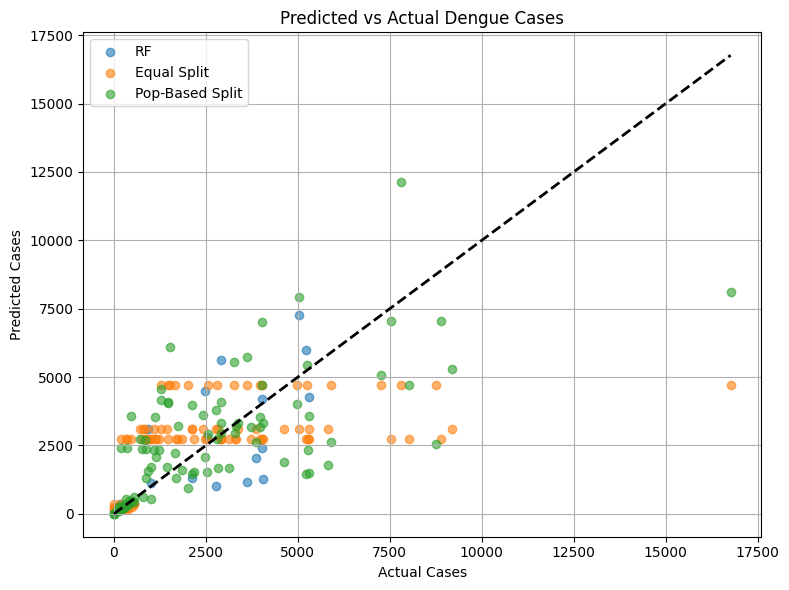

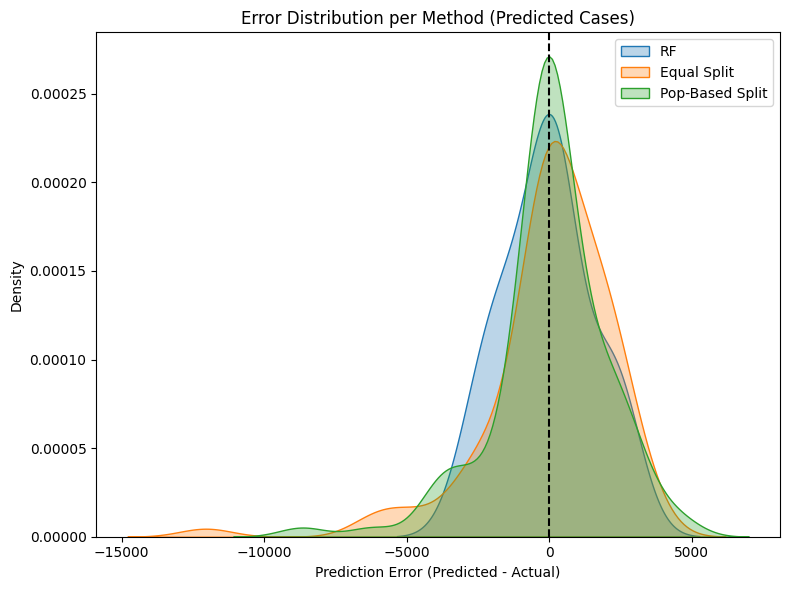

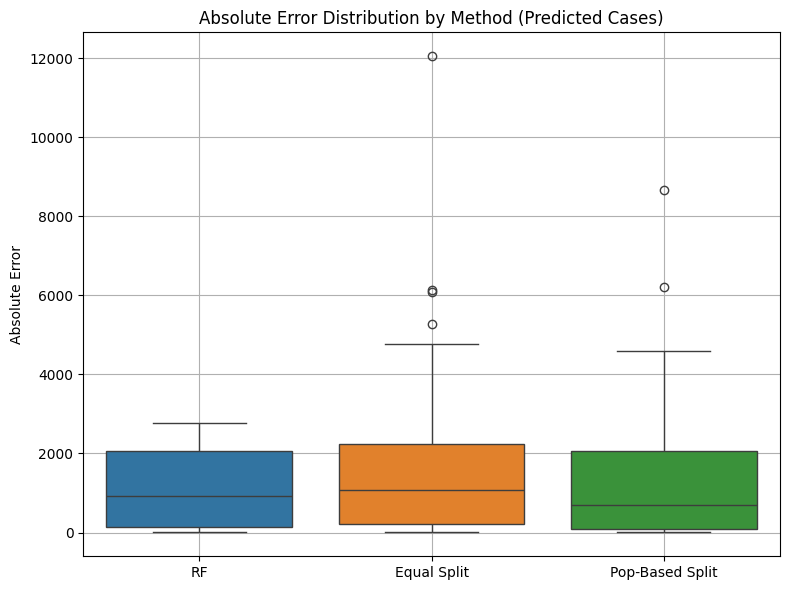


 Wilcoxon Signed-Rank Tests (Absolute Errors):
RF vs Equal Split: p = 0.3118 → no significant difference
RF vs Pop-Based Split: p = 0.6742 → no significant difference
Equal Split vs Pop-Based Split: p = 0.1222 → no significant difference


In [ ]:
# evaluation metric for predicted cases
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import wilcoxon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Define prediction columns and ground truth
case_methods = {
    'RF': 'rf_preds',
    'Equal Split': 'cases_bm_equal',
    'Pop-Based Split': 'cases_prop_bm'
}

true_cases_col = 'Cases'
method_names = list(case_methods.keys())

# Step 1: Metrics
results = []
preds_dict = {}
abs_errors = {}

for name, col in case_methods.items():
    valid_idx = icer[col].notna()
    true = icer.loc[valid_idx, true_cases_col]
    pred = icer.loc[valid_idx, col]

    preds_dict[name] = {'true': true, 'pred': pred}
    abs_errors[name] = abs(pred - true)

    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))

    # Normalized MAE as % of average observed cases per district
    avg_true = np.mean(true)
    if avg_true != 0:
        norm_mae_pct = (mae / avg_true) * 100
    else:
        norm_mae_pct = np.nan  # Handle potential divide-by-zero

    results.append({
        'Method': name,
        'MAE': mae,
        'Normalized MAE (%)': norm_mae_pct,
        'RMSE': rmse
    })


results_df = pd.DataFrame(results)
print("\n Performance Metrics for Predicted Cases:")
print(results_df.to_string(index=False))

# Step 2: Scatter Plot - Predicted vs Actual
plt.figure(figsize=(8, 6))
for name, col in case_methods.items():
    valid_idx = icer[col].notna()
    plt.scatter(icer.loc[valid_idx, true_cases_col], icer.loc[valid_idx, col], label=name, alpha=0.6)
min_val, max_val = icer[true_cases_col].min(), icer[true_cases_col].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Predicted vs Actual Dengue Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Boxplot - Absolute Errors
abs_errors_df = pd.DataFrame(abs_errors)
plt.figure(figsize=(8, 6))
sns.boxplot(data=abs_errors_df)
plt.title("Absolute Error Distribution by Method (Predicted Cases)")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()